<a href="https://colab.research.google.com/github/surya81/image-segmentation/blob/main/image_segmentation_using_unet_architecture_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if not os.path.exists('dataset1'):
  !wget -q \
  https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
  !unzip -q dataset1.zip
  !rm dataset1.zip
  !pip install -q torch_snippets pytorch_model_summary

     |████████████████████████████████| 49 kB 2.6 MB/s 
     |████████████████████████████████| 78 kB 3.9 MB/s 
     |████████████████████████████████| 235 kB 39.5 MB/s 
     |████████████████████████████████| 948 kB 43.1 MB/s 
     |████████████████████████████████| 58 kB 5.4 MB/s 
     |████████████████████████████████| 51 kB 6.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [2]:
from torch_snippets import * 
from torchvision import transforms 
from sklearn.model_selection import train_test_split 
device = 'cuda' if torch.cuda.is_available() else "cpu"
from torch.utils.data import Dataset , DataLoader

In [3]:
tfms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [4]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224,224))
        return image, mask
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [5]:
trn_ds = SegData('train')
val_ds = SegData("test")

In [6]:
import matplotlib.pyplot as plt 

In [7]:
trn_dl = DataLoader(trn_ds,batch_size=4,shuffle = True,collate_fn = trn_ds.collate_fn)
val_dl = DataLoader(val_ds,batch_size =4,shuffle = True,collate_fn = val_ds.collate_fn)

In [8]:
def conv(in_channels,out_channels,): 
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size = 3,stride = 1, padding =1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace = True)
                        
  )

In [9]:
def up_conv(in_channels,out_channels):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size = 2,stride = 2),
      nn.ReLU()
  )

In [10]:
from torchvision.models import vgg16_bn 
model = vgg16_bn(pretrained = True)
model


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [11]:
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [12]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
  ce_loss = ce(preds, targets)
  acc = (torch.max(preds, 1)[1] == targets).float().mean()
  return ce_loss, acc

In [13]:
def train_batch(model, data, optimizer, criterion):
  model.train()
  ims, ce_masks = data
  _masks = model(ims)
  optimizer.zero_grad()
  loss, acc = criterion(_masks, ce_masks)
  loss.backward()
  optimizer.step()
  return loss.item(), acc.item()
@torch.no_grad()
def validate_batch(model, data, criterion):
  model.eval()
  ims, masks = data
  _masks = model(ims)
  loss, acc = criterion(_masks, masks)
  return loss.item(), acc.item()

In [14]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 10

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
log = Report(n_epochs)
for ex in range(n_epochs):
  N = len(trn_dl)
  for bx, data in enumerate(trn_dl):
    loss, acc = train_batch(model, data, optimizer, criterion)
    log.record(ex+(bx+1)/N,trn_loss=loss,trn_acc=acc, end='\r')
  N = len(val_dl)
  for bx, data in enumerate(val_dl):
    loss, acc = validate_batch(model, data, criterion)
    log.record(ex+(bx+1)/N,val_loss=loss,val_acc=acc, end='\r')
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 1.143	trn_acc: 0.753	val_loss: 0.877	val_acc: 0.803	(1025.92s - 9233.30s remaining)
EPOCH: 1.000	trn_loss: 1.143	trn_acc: 0.753	val_loss: 0.827	val_acc: 0.818	(1029.29s - 9263.58s remaining)
EPOCH: 1.000	trn_loss: 1.143	trn_acc: 0.753	val_loss: 0.834	val_acc: 0.813	(1032.72s - 9294.44s remaining)
EPOCH: 1.000	trn_loss: 1.143	trn_acc: 0.753	val_loss: 0.819	val_acc: 0.818	(1036.14s - 9325.30s remaining)
EPOCH: 1.000	trn_loss: 1.143	trn_acc: 0.753	val_loss: 0.822	val_acc: 0.816	(1039.53s - 9355.79s remaining)
EPOCH: 1.000	trn_loss: 1.143	trn_acc: 0.753	val_loss: 0.818	val_acc: 0.817	(1042.95s - 9386.59s remaining)
EPOCH: 1.000	trn_loss: 1.143	trn_acc: 0.753	val_loss: 0.823	val_acc: 0.815	(1046.36s - 9417.22s remaining)
EPOCH: 1.000	trn_loss: 1.143	trn_acc: 0.753	val_loss: 0.827	val_acc: 0.814	(1049.74s - 9447.68s remaining)
EPOCH: 1.000	trn_loss: 1.143	trn_acc: 0.753	val_loss: 0.827	val_acc: 0.814	(1053.16s - 9478.41s remaining)
EPOCH: 1.000	trn_loss: 1.143	trn_acc:

100%|██████████| 111/111 [00:00<00:00, 2488.46it/s]


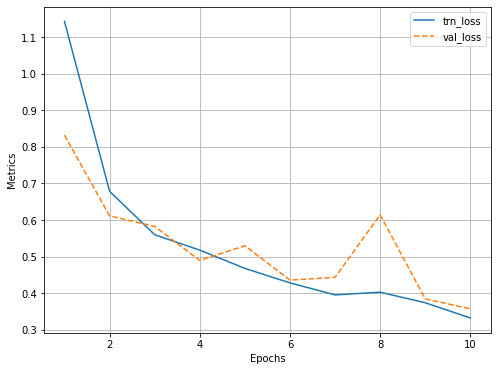

In [16]:
log.plot_epochs(['trn_loss','val_loss'])

In [28]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)


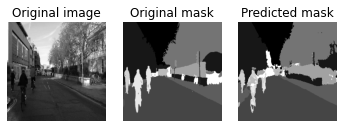

In [29]:
subplots([im[3].permute(1,2,0).detach().cpu()[:,:,0], \
mask.permute(1,2,0).detach().cpu()[:,:,0], \
_mask.permute(1,2,0).detach().cpu()[:,:,0]],nc=3, \
titles=['Original image','Original mask', \
'Predicted mask'])